# Hugging-Face Tutorial

This tutorial will cover some basic operations using the [Transformers](https://huggingface.co/docs/transformers/index) package developed by HuggingFace.

### Transformer Encoder

We will start by showing how you can load a model and a tokenizer, and get contextual embeddings from a pretrained Transformer model. For that we are going to use a smaller version of the [BERT model](https://arxiv.org/abs/1810.04805), the [DistilBERT model](https://arxiv.org/abs/1910.01108).

There are more than [100k models available](https://huggingface.co/models) in the Transformers package. They usually have a short "readme", with some extra details, called the `Model card`. You can find the model card for the specific model we are going to use [here](https://huggingface.co/distilbert-base-uncased).

#### Loading a model / tokenizer

As you know by now, a model like BERT can be used to obtain contextual embedding representations that are later used to solve a task. Depending on the use case you will need to use different classification layers and strategies to extract/pool the embeddings you need. The Transformers package already includes specific models for those different cases. E.g., the class `AutoModelForTokenClassification` includes a `token classification head`, which corresponds to a linear layer on top of the contextual embeddings.

Furthermore, if you are sure about the model architecture you want to use, for example in this case a BERT model, you can use `BertModel`, or even `BertForTokenClassification`, if that's the class of problems you want to solve. However, we are going to start with the most generic possible case, where we use the class `AutoModel` that will instantiate the correct architecture based on the model you choose from the repository of available models.

Different model use different [tokenization strategies](https://blog.floydhub.com/tokenization-nlp/). Thus, you also need to download the correct tokenizer for your model. This is as simple as using the model name for the tokenizer class. As with the model, you can use the corresponding class, e.g. `BertTokenizer`, but we are going to use `AutoTokenizer`, which loads the correct tokenizer based on the model name you provide.

In [ ]:
#Uncomment for Colab
#!pip install transformers==4.26.*
#!pip install datasets==2.10.*

In [ ]:
import torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
model = AutoModel.from_pretrained("distilbert-base-cased")

We can confirm which class the model used for both the tokenizer and the model.

In [ ]:
print("Model    : ", type(model))
print("Tokenizer: ", type(tokenizer))

We will now define two simple input sentences, and call the tokenizer and the model.

In [ ]:
x = ["Today is Tuesday.", "A cold morning in Science Park."]

In [ ]:
batch = tokenizer(x, padding=True, return_tensors="pt")
batch

After tokenizing we have the [`input_ids`](https://huggingface.co/docs/transformers/v4.26.1/en/glossary#input-ids) and the [`attention_mask`](https://huggingface.co/docs/transformers/v4.26.1/en/glossary#attention-mask), which are the inputs to the model.

Before we call the model, let's confirm that the model already includes the necessary special tokens by calling the method `convert_ids_to_tokens` of the tokenizer.

In [ ]:
tokenizer.convert_ids_to_tokens(batch["input_ids"][1])

And now we can call the contextual embedding model.

In [ ]:
output = model(**batch)
print("Output keys: ", output.keys())
print("\nOutput shape: ", output["last_hidden_state"].shape)
print("\nOutput: ", output["last_hidden_state"])

We can see that the model only returns what is called the `last_hidden_state`, which corresponds to the hidden states of the top layer, with dimensions `[batch_size, sequence_length, hidden_size]`.

We can also choose to output the hidden states for all layers and the attention weights of the self-attention mechanism, as described in the [docs](https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/distilbert#transformers.DistilBertModel.forward) for the model we are using.

In [ ]:
output = model(**batch, output_attentions=True, output_hidden_states=True)
print("Output keys: ", output.keys())

Hidden states is a tuple with `num_layers + 1` tensors, one for each layer plus the embedding layer, each with shape `[batch_size, sequence_length, hidden_size`].

In [ ]:
print("Number items in 'hidden_states': ", len(output['hidden_states']))
print("'hidden_states' shape: ", output["hidden_states"][0].shape)

We can confirm that the `last_hidden_state` indeed corresponds to the top layer of the model.

In [ ]:
assert torch.all(output["last_hidden_state"] == output["hidden_states"][-1])

For the attentions we get a tuple with `num_layers` tensors, one for each layer, each with shape `[batch_size, num_heads, sequence_length, sequence_length]`. These values can be visualized similarly to what we did in previous tutorials.

In [ ]:
print("Number items in 'attentions': ", len(output['attentions']))
print("'attentions' shape: ", output["attentions"][0].shape)

---

#### Models finetuned for specific tasks

As mentioned before we need to train a classification layer to use the embeddings extracted from our Transformer model in case we want to solve a downstream task. This depends on the task. For instance for a token-level classification task we could apply a linear classifier on top of every embedding, whereas for a sentence-level classification task we could apply a linear classifier on top of the representation of the `CLS` token.

A brief overview of the different strategies can be seen in the following figure from the [original BERT paper](https://arxiv.org/abs/1810.04805):

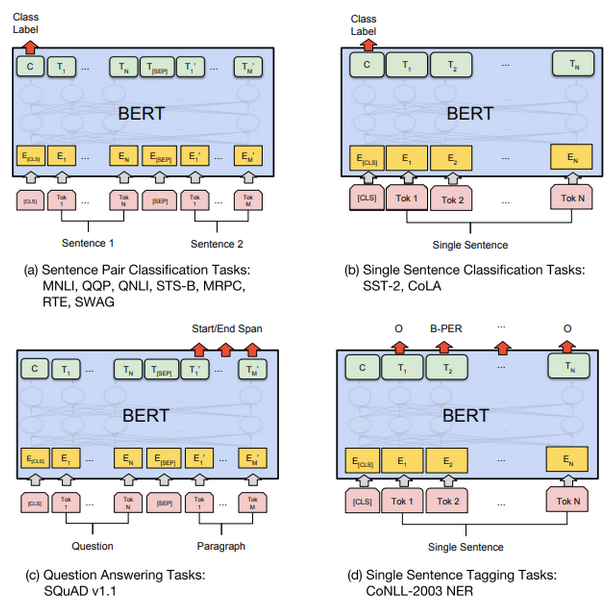

For now we are going to skip how you can actually finetune an existing model. However, we are going to go through two different ways of using an already trained model. For common datasets/models it is common to find already finetuned instances in the HuggingFace model repository. Let's explore [one such model](https://huggingface.co/distilbert-base-cased-distilled-squad), previously finetuned on a dataset specific to the Question-Answering task.

In [ ]:
from transformers import DistilBertForQuestionAnswering

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-cased-distilled-squad')

In [ ]:
context = "Paris is the capital of France. Madrid is the capital of Spain. Barcelona is a city in Spain."
question = "What is the capital of Spain?"

batch = tokenizer(question, context, return_tensors="pt")
output = model(**batch)

output.keys()

Notice how this model now returns an output specific to the task we want to solve.

In [ ]:
answer_start_index = torch.argmax(output["start_logits"])
answer_end_index = torch.argmax(output["end_logits"])
print("Answer start index: ", answer_start_index)
print("Answer end index: ", answer_end_index)

In [ ]:
tokenizer.decode(batch["input_ids"][0][answer_start_index:answer_end_index+1])

---

#### Pipelines

Another way of making using of already trained models is via what HuggingFace calls ["pipelines"](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/pipelines#transformers.pipeline). There are several pipelines implemented for different tasks (e.g. Translation, Text Generation, QA, etc.) and they simplify even further how you can interact with an already existing model.

Here we are going to use a pipeline for QA, with exactly the same model we have been using so far.

In [ ]:
from transformers import pipeline

In [ ]:
qa_pipeline = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

In [ ]:
context = "Paris is the capital of France. Madrid is the capital of Spain. Barcelona is a city in Spain."

In [ ]:
for question in ["What is the capital of Spain?", "What is the capital of France?", "Where is Barcelona?"]:
    print(f"Question: {question} - {qa_pipeline(question=question, context=context)}")

Let's use a longer context and test the pipeline model once again.

In [ ]:
context = "The University of Amsterdam (abbreviated as UvA, Dutch: Universiteit van Amsterdam) "\
          + "is a public research university located in Amsterdam, Netherlands. Established in 1632 " \
          + "by municipal authorities and later renamed for the city of Amsterdam, the University of " \
          + "Amsterdam is the third-oldest university in the Netherlands, and one of the most " \
          + "prestigious academic institutions of the country, and in the world."

In [ ]:
qa_pipeline(question="When was UvA founded?", context=context)

In [ ]:
qa_pipeline(question="Who established UvA?", context=context)

In [ ]:
qa_pipeline(question="How recognized is UvA?", context=context)

---
---
---

### Transformer Decoder

Let's now focus on a Transformer decoder model. In this case we are going to use the [`distilgpt2`](https://huggingface.co/distilgpt2) model, a smaller version of GPT-2.

In [ ]:
from transformers import GPT2LMHeadModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("distilgpt2")

In [ ]:
x = "A cold morning in Science Park, where we are learning about"

In [ ]:
batch = tokenizer(x, return_tensors="pt")
batch

We can start by generating some text based on the original model. There are many [options](https://huggingface.co/blog/how-to-generate) to do so, we will just use beam search.

In [ ]:
output = model.generate(**batch, num_beams=5, max_length=30)
output.shape

In [ ]:
tokenizer.decode(output[0], skip_special_tokens=True)

Since we loaded the `LMHeadModel`, calling it returns a set of logit values, with dimension `[batch_size, sequence_length, vocab_dim]`.

In [ ]:
logits = model(**batch, use_cache=False)["logits"]
logits.shape

We can then calculate the loss manually: first we apply log-softmax to the logits output by the model; then, we select the values for the correct position (offset by one, meaning that you select the value corresponding to the next token for a given position); and then average the results.

In [ ]:
logits = torch.nn.functional.log_softmax(logits, dim=-1)
logits = logits[:, :-1]
batch_size, sequence_length, vocab_dim = logits.shape
loss = torch.mean(
    logits.reshape(-1, vocab_dim)[torch.arange(batch_size*sequence_length), batch["input_ids"][:, 1:].reshape(-1)]
)
print(-1*loss)

In practice we don't need to do it manually, as the Transformers package does the same if we provide the labels to the model, i.e., the original `input_ids`.

In [ ]:
model(**batch, labels=batch["input_ids"])["loss"]

---

#### Datasets

Now that we are going to finetune a model, it's a good a time to introduce a very useful package, also developed by HuggingFace. The [datasets](https://huggingface.co/datasets) package contains several different datasets, for different tasks and even types of data.

In [ ]:
import datasets
datasets.disable_progress_bar()

For this section we are going to use the English split of the [\"Amazon Reviews Corpus\"](https://huggingface.co/datasets/amazon_reviews_multi).

In [ ]:
data = datasets.load_dataset("amazon_reviews_multi", "en")

In [ ]:
data

In [ ]:
set(data["train"]["product_category"])

As we can see there are many different categories in this dataset. In order to keep things simpler we are going to use only the reviews for the "sports" product category. Plus, we are going to filter out the longer example, to speed up training.

In [ ]:
def preprocess_data(data):
    data = data.remove_columns(["review_id", "product_id", "reviewer_id", "stars", "language"])
    data = data.filter(lambda x: x["product_category"] == "sports")
    data = data.filter(lambda x: len(x["review_body"].split()) < 30)
    return data

In [ ]:
train_data_preprocessed = preprocess_data(data["train"])
valid_data_preprocessed = preprocess_data(data["validation"])
test_data_preprocessed = preprocess_data(data["test"])

The goal of our model will be to predict the title of the review. Our input will be the review of the product, followed by `TITLE: `, the actual title, and the end of sentence token.

In [ ]:
def prepare_dataset(data, tokenizer):
    return [f"{x['review_body']} TITLE: {x['review_title']}{tokenizer.eos_token}" for x in data]

In [ ]:
train_data = prepare_dataset(train_data_preprocessed, tokenizer)
valid_data = prepare_dataset(valid_data_preprocessed, tokenizer)
test_data = prepare_dataset(test_data_preprocessed, tokenizer)
print(f"Train: {len(train_data)} examples")
print(f"Valid: {len(valid_data)} examples")
print(f"Test: {len(test_data)} examples")

In [ ]:
train_data[0]

---

#### Training Model

Now that we have prepared our dataset, we are going to implement everything we need to actually train the model.

In [ ]:
import random
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    
set_random_seed(0)

In [ ]:
config = {
    "num_epochs": 10,
    "learning_rate": 3e-5,
    "warmup_ratio": 0.1,
    "batch_size": 8,
}

#### Define dataset and dataloaders

In [ ]:
class GPTDataset(Dataset):
    
    def __init__(self, tokenizer, data):
        
        self.tokenizer = tokenizer
        self.data = data
        self.num_examples = len(data)

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, batch):
        
        batch_tensor = self.tokenizer(
            batch,
            padding="longest",
            return_tensors="pt",
        )
        
        # A bit hacky, but we prepare "labels" to obtain the loss, as explained in:
        # https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/gpt2#transformers.GPT2LMHeadModel.forward.labels
        labels = torch.ones_like(batch_tensor["input_ids"]) * -100
        for example_idx, example in enumerate(batch_tensor["input_ids"]):
            
            # Find the position of "TITLE:"
            # We need to do this, as different words might be mapped to multiple subwords
            example_tokens = self.tokenizer.convert_ids_to_tokens(example, skip_special_tokens=True)
            labels_start_idx = example_tokens.index("ĠTIT")
            assert example_tokens[labels_start_idx + 1] == "LE"
        
            # Replace labels by original ids, only for the title, and keep the eos token
            # The EOS token is the same as the PAD token, but since we do this based on the length
            # of the example tokens, everything works as intended
            labels[example_idx][labels_start_idx : len(example_tokens) + 1] = \
                batch_tensor["input_ids"][example_idx][labels_start_idx : len(example_tokens) + 1]
            
        batch_tensor["labels"] = labels

        return batch_tensor

In [ ]:
train_dataset = GPTDataset(tokenizer, train_data)
valid_dataset = GPTDataset(tokenizer, valid_data)

In [ ]:
train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=config["batch_size"], collate_fn=train_dataset.collate_fn
)
valid_dataloader = DataLoader(
    valid_dataset, shuffle=False, batch_size=config["batch_size"], collate_fn=valid_dataset.collate_fn
)

#### Define optimizer and scheduler

In [ ]:
def prepare_optimizer(model, lr):
    return AdamW(model.parameters(), lr=lr, eps=1e-8)

In [ ]:
optimizer = prepare_optimizer(
    model=model,
    lr=config["learning_rate"],
)

In order to use a linear scheduler (that we discussed in a previous tutorial) we need to calculate the number of training steps.

In [ ]:
def prepare_scheduler(optimizer, train_dataloader, config):
    total_steps = len(train_dataloader) * config["num_epochs"]

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(config["warmup_ratio"] * total_steps),
        num_training_steps=total_steps,
    )
    
    return scheduler

In [ ]:
scheduler = prepare_scheduler(
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    config=config,
)

#### Define trainable layers

Since we are working with a small dataset, letting the model be fully trained might be too much. So we "freeze" most of the layers of the model, except for the top layer and the linear function that maps the hidden states to the vocab dimension.

In [ ]:
num_layers = model.config.n_layer

In [ ]:
num_trainable_layers = 1
trainable_layers = [str(i) for i in range(num_layers - num_trainable_layers, num_layers)]

# Unfreeze layer as desired
for param_name, param in model.named_parameters():
    if not param_name.split(".")[1] == "ln_f" and not param_name.split(".")[2] in trainable_layers:
        param.requires_grad = False
    else:
        param.requires_grad = True

# Print layers that are going the be trained
print("Layers being trained:\n")
for param_name, param in model.named_parameters():
    if param.requires_grad == True:
        print(param_name)

#### Get device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
model = model.to(device)

#### Train model / Generate examples

Let's start by generating some samples before training the model. We can see that the model generates titles that are clearly not relevant.

In [ ]:
def generate_with_model(text, tokenizer, model, device):
    tokenized_text = tokenizer(text, return_tensors="pt").to(device)
    generated_text_ids = model.generate(
        **tokenized_text,
        max_length=70,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,
    )[0]
    generated_text = tokenizer.decode(generated_text_ids, skip_special_tokens=True)
    return generated_text

In [ ]:
def pretty_print_example(context, original, generated):
    print(f"Context:\n{context}\n")
    original_title = original.split("TITLE: ")[1]
    print(f"Original:\n{original_title[:-len(tokenizer.eos_token)]}\n")
    generated_title = generated.split("TITLE: ")[1]
    print(f"Generated:\n{generated_title.strip()}\n")

    print("-----")

In [ ]:
for i in range(5):
    example = valid_data[i][:valid_data[i].index("TITLE:") + len("TITLE:")]
    generated_example = generate_with_model(example, tokenizer, model, device)
    pretty_print_example(context=example, original=valid_data[i], generated=generated_example)

We can finally train our model.

In [ ]:
batch_loss = -100

for epoch in range(config["num_epochs"]):

    total_train_loss = 0
    
    model.train()

    for step_idx, batch in enumerate(train_dataloader):

        #print(f"STEP: {step_idx} / {len(train_dataloader)} - LOSS: {batch_loss:.4f}", end="\r")
        # Use this one for Colab instead:
        print(f"\rSTEP: {step_idx} / {len(train_dataloader)} - LOSS: {batch_loss:.4f}", end="")

        model.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}
        output = model(**batch)

        batch_loss = output["loss"]
        total_train_loss += batch_loss.item()

        batch_loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"\nEpoch: {epoch} - Average Train Loss: {total_train_loss / len(train_dataloader):.2f}")

    # Validation
    model.eval()

    total_valid_loss = 0

    for batch in valid_dataloader:
        
        batch = {k:v.to(device) for k,v in batch.items()}
        
        with torch.no_grad():
            output = model(**batch)
    
        batch_loss = output["loss"].item()
        total_valid_loss += batch_loss
        
    print(f"Epoch: {epoch} - Average Valid Loss: {total_valid_loss / len(valid_dataloader):.2f}")

In [ ]:
for i in range(5):
    example = valid_data[i][:valid_data[i].index("TITLE:") + len("TITLE:")]
    generated_example = generate_with_model(example, tokenizer, model, device)
    pretty_print_example(context=example, original=valid_data[i], generated=generated_example)

The model is now able to generate titles that are a bit closer to the expected.

---
---
---

### Transformer Encoder-Decoder

After working both with Encoder and Decoder only transformers, it's now time to explore a Transformer Encoder-Decoder model. Similarly to what we did so far, we are going to use a an already existing model, in this case the [small version of T5](https://huggingface.co/t5-small). You can read more about this model in the [corresponding paper](https://jmlr.org/papers/volume21/20-074/20-074.pdf).

In [ ]:
from transformers import T5ForConditionalGeneration

In [ ]:
set_random_seed(0)

In [ ]:
t5_config = {
    "num_epochs": 10,
    "learning_rate": 3e-5,
    "warmup_ratio": 0.1,
    "batch_size": 8,
}

#### Load model and tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

#### Prepare data

In this case we are going to give the content of the review to the encoder, and let the decoder generate the title.

In [ ]:
def prepare_dataset(data, tokenizer):
    return [(f"{x['review_body']}", f"{x['review_title']}{tokenizer.eos_token}") for x in data]

In [ ]:
train_data = prepare_dataset(train_data_preprocessed, tokenizer)
valid_data = prepare_dataset(valid_data_preprocessed, tokenizer)
test_data = prepare_dataset(test_data_preprocessed, tokenizer)
print(f"Train: {len(train_data)} example")
print(f"Valid: {len(valid_data)} example")
print(f"Test: {len(test_data)} example")

In [ ]:
train_data[0]

#### Define dataset and dataloaders

In [ ]:
class T5Dataset(Dataset):
    
    def __init__(self, tokenizer, data):
        
        self.tokenizer = tokenizer
        self.data = data
        self.num_examples = len(data)

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, batch):
        
        tokenized_review = self.tokenizer(
            [x[0] for x in batch],
            padding="longest",
            return_tensors="pt",
        )
        
        tokenized_title = self.tokenizer(
            [x[1] for x in batch],
            padding="longest",
            return_tensors="pt",
        )

        return {"tokenized_review": tokenized_review,
                "tokenized_title": tokenized_title}

In [ ]:
train_dataset = T5Dataset(tokenizer, train_data)
valid_dataset = T5Dataset(tokenizer, valid_data)

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=t5_config["batch_size"],
    collate_fn=train_dataset.collate_fn,
)
valid_dataloader = DataLoader(
    valid_dataset,
    shuffle=False,
    batch_size=t5_config["batch_size"],
    collate_fn=valid_dataset.collate_fn,
)

#### Define optimizer and scheduler

In [ ]:
optimizer = prepare_optimizer(
    model=model,
    lr=t5_config["learning_rate"],
)

In [ ]:
scheduler = prepare_scheduler(
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    config=t5_config,
    
)

#### Move model to the right device

In [ ]:
model = model.to(device)

#### Define trainable layers

In [ ]:
num_layers = model.config.num_layers

In [ ]:
num_trainable_layers = 1
trainable_layers = [str(i) for i in range(num_layers - num_trainable_layers, num_layers)]

# Unfreeze layer as desired
for param_name, param in model.named_parameters():
    if param_name.split(".")[0] in ["encoder", "decoder"] and param_name.split(".")[2] in trainable_layers:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Print layers that are going the be trained
print("Layers being trained:\n")
for param_name, param in model.named_parameters():
    if param.requires_grad == True:
        print(param_name)

#### Train Model / Generate Examples

In [ ]:
def generate_with_model(text, tokenizer, model, device):
    tokenized_text = tokenizer(text, return_tensors="pt").to(device)
    
    generated_text_ids = model.generate(
        input_ids=tokenized_text["input_ids"],
        attention_mask=tokenized_text["attention_mask"],
        max_length=70,
        pad_token_id=tokenizer.eos_token_id
    )[0]
    generated_text = tokenizer.decode(generated_text_ids, skip_special_tokens=True)
    return generated_text

In [ ]:
def pretty_print_example(original, generated):
    print(f"Context:\n{original[0]}\n")
    original_title = original[1]
    print(f"Original:\n{original_title[:-len(tokenizer.eos_token)]}\n")
    generated_title = generated
    print(f"Generated:\n{generated_title}\n")

    print("-----")

In [ ]:
valid_data[i]

In [ ]:
for i in range(5):
    example = valid_data[i][0]
    generated_example = generate_with_model(example, tokenizer, model, device)
    pretty_print_example(original=valid_data[i], generated=generated_example)

For a better understanding of the forward call, refer to the [corresponding docs page](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration.forward).

In [ ]:
batch_loss = -100

for epoch in range(t5_config["num_epochs"]):

    total_train_loss = 0
    
    model.train()

    for step_idx, batch in enumerate(train_dataloader):

        #print(f"STEP: {step_idx} / {len(train_dataloader)} - LOSS: {batch_loss:.4f}", end="\r")
        # Use this one for Colab instead:
        print(f"\rSTEP: {step_idx} / {len(train_dataloader)} - LOSS: {batch_loss:.4f}", end="")

        model.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}
        output = model(
            input_ids=batch["tokenized_review"]["input_ids"],
            attention_mask=batch["tokenized_review"]["attention_mask"],
            labels=batch["tokenized_title"]["input_ids"],
            decoder_attention_mask=batch["tokenized_title"]["attention_mask"],
        )

        batch_loss = output["loss"]
        total_train_loss += batch_loss.item()

        batch_loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"\nEpoch: {epoch} - Average Train Loss: {total_train_loss / len(train_dataloader):.2f}")

    # Validation
    model.eval()

    total_valid_loss = 0

    for batch in valid_dataloader:
        
        batch = {k:v.to(device) for k,v in batch.items()}

        with torch.no_grad():
            output = model(
                input_ids=batch["tokenized_review"]["input_ids"],
                attention_mask=batch["tokenized_review"]["attention_mask"],
                labels=batch["tokenized_title"]["input_ids"],
                decoder_attention_mask=batch["tokenized_title"]["attention_mask"],
            )
    
        batch_loss = output["loss"].item()
        total_valid_loss += batch_loss
        
    print(f"Epoch: {epoch} - Average Valid Loss: {total_valid_loss / len(valid_dataloader):.2f}")

In [ ]:
for i in range(5):
    example = valid_data[i][0]
    generated_example = generate_with_model(example, tokenizer, model, device)
    pretty_print_example(original=valid_data[i], generated=generated_example)

---
---
---

### Resources

**General**

- [HuggingFace Course](https://huggingface.co/course/chapter1/1)
- [Transformers Package Docs](https://huggingface.co/docs/transformers/index)

**Finetuning Tutorials**
- Finetuning with HF Trainer Package: [(1)](https://huggingface.co/docs/transformers/training#train-with-pytorch-trainer) and [(2)](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/trainer#trainer).
- [Finetuning with PyTorch](https://huggingface.co/docs/transformers/training#train-in-native-pytorch)

**HuggingFace Examples**
- [HuggingFace Official Notebooks](https://huggingface.co/docs/transformers/notebooks)
- [HuggingFace Community Notebooks](https://huggingface.co/docs/transformers/community)
- [HuggingFace PyTorch Script Examples](https://github.com/huggingface/transformers/tree/main/examples/pytorch)

**Other**
- To work with [adapters](https://arxiv.org/abs/1902.00751): [AdapterHub](https://docs.adapterhub.ml/)
- Prompting strategies with GPT-3: [OpenAI github document](https://github.com/openai/openai-cookbook/blob/main/techniques_to_improve_reliability.md)